In [1]:
from unityagents import UnityEnvironment
from collections import deque

import numpy as np
import progressbar as pb

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
import gym
from baselines.common.vec_env.subproc_vec_env import SubprocVecEnv
env_name = 'LunarLanderContinuous-v2'

env = gym.make(env_name)
action_size = env.action_space.shape[0]
state_size = env.observation_space.shape[0]

num_agents = 20

def make_env(env_id, seed):
    def _f():
        env = gym.make(env_id)
        env.seed(seed)
        return env
    return _f

envs = [make_env(env_name, seed) for seed in range(num_agents)]
envs = SubprocVecEnv(envs)

def interact(action):
    if np.isnan(action).any():
        print("ACHTUNG")
    action = action.reshape(num_agents, action_size) 
    next_state, reward, done, _ = envs.step(action)
    return next_state.reshape(num_agents, -1), np.array(reward).reshape(num_agents, -1), np.array(done).reshape(num_agents, -1)

def get_random_action():
    actions = []
    for _ in range(num_agents):
        action = envs.action_space.sample()
        actions.append(action)
    return np.array(actions).reshape(num_agents, -1)
    
def reset():
    state = envs.reset()
    return state.reshape(num_agents, -1)

In [4]:
NET_SIZE = 256

class Policy(nn.Module):
    
    def __init__(self, state_size, action_size=1, n_agents=1, fc1_size=NET_SIZE, fc2_size=NET_SIZE):
        super(Policy, self).__init__()
        
        self.fc1 = nn.Linear(state_size, fc1_size)
        self.fc2 = nn.Linear(fc1_size, fc2_size)
        self.fc3_mu = nn.Linear(fc2_size, action_size)
        self.fc3_std = nn.Linear(fc2_size, action_size)

    def forward(self, state):
        x = torch.relu(self.fc1(state)) 
        x = torch.relu(self.fc2(x))

        mean = torch.tanh(self.fc3_mu(x))
        std = torch.sigmoid(self.fc3_std(x))
        
        return torch.distributions.Normal(mean, std)
    
class Value(nn.Module):
    
    def __init__(self, state_size, action_size=1, n_agents=1, fc1_size=NET_SIZE, fc2_size=NET_SIZE):
        
        super(Value, self).__init__()
        
        self.fc1 = nn.Linear(state_size, fc1_size)
        self.fc2 = nn.Linear(fc1_size, fc2_size)
        self.fc3 = nn.Linear(fc2_size, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)
    
class Q(nn.Module):
    
    def __init__(self, state_size, action_size, n_agents=1, fc1_size=NET_SIZE, fc2_size=NET_SIZE):
        
        super(Q, self).__init__()
        
        self.fc1_s = nn.Linear(state_size, fc1_size)
        self.fc1_a = nn.Linear(action_size, fc1_size)
        self.fc2 = nn.Linear(fc1_size, fc2_size)
        self.fc3 = nn.Linear(fc2_size, 1)
        
    def forward(self, s, a):
        x_s = torch.relu(self.fc1_s(s)) 
        x_a = torch.relu(self.fc1_a(a))
        x = torch.tanh(self.fc2(x_s + x_a))
        return self.fc3(x)

In [5]:
from agent import Agent

agent = Agent(
    state_size=state_size, 
    action_size=action_size,
    policy_network=Policy,
    value_network=Value,
    q_network=Q,
    n_agents=num_agents, 
    device=device,
)

D:\Anaconda\envs\gym\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda\envs\gym\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda\envs\gym\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda\envs\gym\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:544: FutureWa

In [6]:
# agent.policy_network.load_state_dict(torch.load("POLICY.pth"))
# agent.value_network_local.load_state_dict(torch.load("VALUE_LOCAL.pth"))
# agent.value_network_target.load_state_dict(torch.load("VALUE_LOCAL.pth"))
# agent.q_network_1.load_state_dict(torch.load("Q_1.pth"))
# agent.q_network_2.load_state_dict(torch.load("Q_2.pth"))

In [7]:
def run(n_episodes, t_max, print_every):
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=print_every)  # last 100 scores
    widget = ['training loop: ', pb.Percentage(), ' ', pb.Bar(), ' ', pb.ETA()]
    timer = pb.ProgressBar(widgets=widget, maxval=n_episodes).start()
    
    frame_counter = 0
    
    for i_episode in range(1, n_episodes+1):
        states = reset()
        score = 0
        for t in range(t_max):
            frame_counter += 1
            actions = agent.act(states)
            next_states, rewards, dones = interact(actions)
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            score += rewards.mean()
            if np.any(dones):
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        agent.writer.add_scalar('score/mean', score)
        if i_episode % print_every == 0:
            print('\rEpisode {}\tScore Mean: {:.2f}\tScore STD: {:.2f}'.format(i_episode, np.mean(scores_window), np.std(scores_window)))
            
        timer.update(i_episode)
    return scores

In [8]:
%time scores = run(t_max=int(500), n_episodes=int(1e4), print_every=100)

training loop:   0% |                                          | ETA:   4:51:35

Episode 100	Score Mean: -352.96	Score STD: 119.45


training loop:   1% |                                          | ETA:   4:46:20

Episode 200	Score Mean: -475.54	Score STD: 36.83


training loop:   2% |                                          | ETA:   4:44:49

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |                                          | ETA:   4:45:02

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |                                          | ETA:   4:45:01

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:44:59

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:44:50

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:44:40

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:44:32

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:44:23

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:44:14

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:44:09

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:44:01

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:43:53

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:43:47

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:43:40

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:43:30

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:43:23

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:43:15

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:43:07

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:43:05

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:42:58

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:42:52

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:42:45

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:42:37

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:42:30

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:42:26

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:42:19

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:42:19

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:42:14

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:42:12

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:42:10

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:42:07

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:42:02

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:41:59

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:41:56

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:41:49

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:41:39

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:41:34

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:41:28

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:41:24

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:41:21

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:41:13

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:41:07

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:41:02

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:40:58

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:40:54

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:40:48

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:40:39

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:40:34

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:40:28

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:40:20

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:40:16

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:40:12

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:40:05

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:39:58

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:39:56

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:39:58

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:39:51

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:39:48

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:39:42

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:39:38

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:39:32

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:39:27

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:39:24

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   2% |#                                         | ETA:   4:39:19

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
Episode 300	Score Mean: -197.38	Score STD: 199.47


training loop:   3% |#                                         | ETA:   4:39:13

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:39:05

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:39:02

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:38:57

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:38:50

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:38:46

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:38:39

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:38:31

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:38:25

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:38:21

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:38:12

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:38:08

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:38:06

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:38:04

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:38:05

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:38:02

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:37:58

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:37:57

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:37:54

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:37:49

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:37:45

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:37:43

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:37:37

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:37:33

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:37:28

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:37:21

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:37:16

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:37:12

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:37:08

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:37:03

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:36:57

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:36:53

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:36:51

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:36:47

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:36:44

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:36:41

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:36:37

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:36:32

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:36:28

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:36:26

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:36:22

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:36:19

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:36:17

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:36:13

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:36:11

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:36:07

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:36:02

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:36:00

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:35:55

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:35:56

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:35:56

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:35:53

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:35:50

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:35:49

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:35:47

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:35:46

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:35:41

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:35:39

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:35:37

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:35:33

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:35:31

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:35:29

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:35:26

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:35:23

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:35:21

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:35:15

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:35:13

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:35:11

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:35:08

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:35:03

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:35:00

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:34:57

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:34:53

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:34:51

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:34:49

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:34:47

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:34:42

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:34:41

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:34:47

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:34:44

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:34:45

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:34:42

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:34:40

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:34:40

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:34:38

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:34:36

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:34:35

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:34:35

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:34:34

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:34:32

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:34:32

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:34:34

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:34:29

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:34:28

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:34:25

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:34:21

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:34:19

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:34:15

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:34:10

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   3% |#                                         | ETA:   4:34:08

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
Episode 400	Score Mean: -46.23	Score STD: 4.21


training loop:   4% |#                                         | ETA:   4:34:05

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   4% |#                                         | ETA:   4:34:01

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   4% |#                                         | ETA:   4:33:58

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   4% |#                                         | ETA:   4:33:56

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   4% |#                                         | ETA:   4:33:53

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   4% |#                                         | ETA:   4:33:49

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   4% |#                                         | ETA:   4:33:44

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   4% |#                                         | ETA:   4:33:43

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   4% |#                                         | ETA:   4:33:42

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   4% |#                                         | ETA:   4:33:42

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   4% |#                                         | ETA:   4:33:39

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   4% |#                                         | ETA:   4:33:36

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   4% |#                                         | ETA:   4:33:36

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   4% |#                                         | ETA:   4:33:36

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   4% |#                                         | ETA:   4:33:34

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   4% |#                                         | ETA:   4:33:33

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   4% |#                                         | ETA:   4:33:36

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


training loop:   4% |#                                         | ETA:   4:33:34

ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG
ACHTUNG


KeyboardInterrupt: 

NameError: name 'scores' is not defined

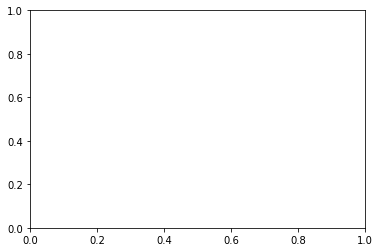

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()